[*********************100%***********************]  1 of 1 completed
C:\Users\ELCOT\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Price            Close        High         Low        Open      Volume
Ticker     RELIANCE.NS RELIANCE.NS RELIANCE.NS RELIANCE.NS RELIANCE.NS
Date                                                                  
2015-01-01  189.999847  190.877201  189.090396  189.657477     2963643
2015-01-02  189.496948  191.743828  189.229471  190.042616     7331366
2015-01-05  187.421265  190.641790  187.046782  189.379255    10103941
2015-01-06  178.915222  186.811376  178.037869  186.169417    18627980
2015-01-07  182.809845  183.772792  179.107860  179.129258    20720312
Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.0077 - val_loss: 0.0023
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 2.7135e-04 - val_loss: 5.7774e-04
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 2.1841e-04 - val_loss: 4.5413e-04
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 2.1292e-04 - val_loss: 4.0769e-04
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 1.9867e-0

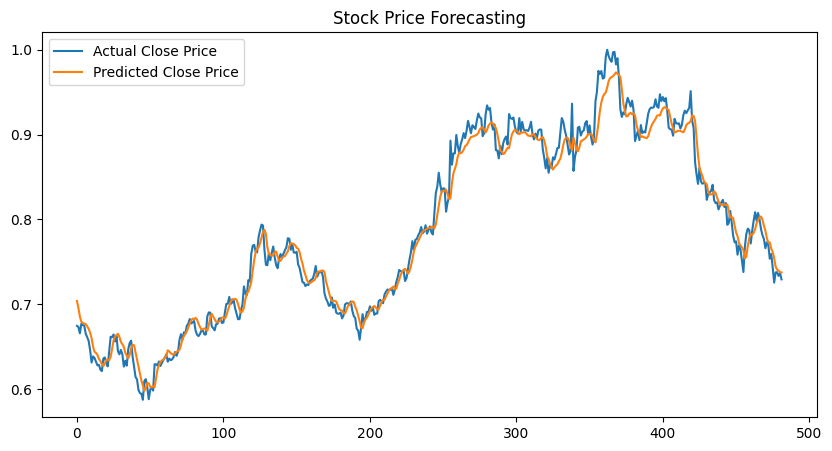

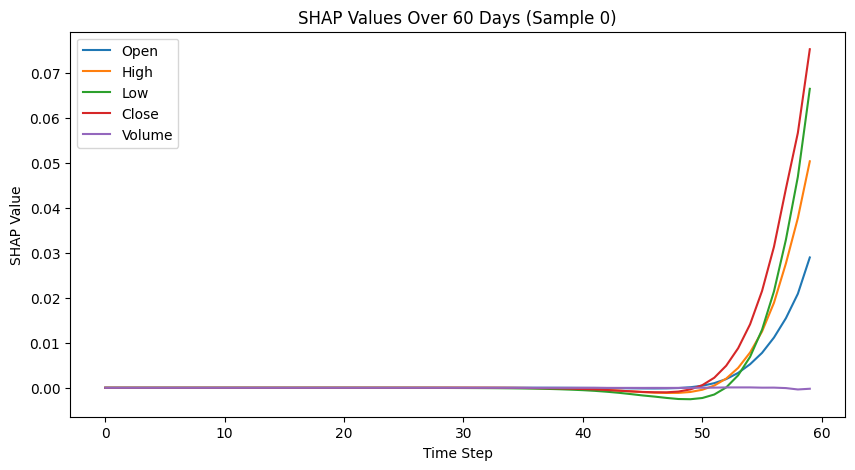

SHAP shape: (10, 60, 5, 1)


C:\Users\ELCOT\AppData\Local\Temp\ipykernel_26904\1907507370.py:145: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(
C:\Users\ELCOT\AppData\Local\Programs\Python\Python310\lib\site-packages\shap\plots\_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


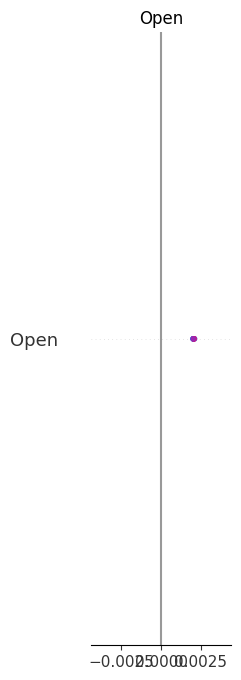

In [5]:
# ==========================================
# Advanced Stock Market Forecasting
# LSTM + Explainability (SHAP)
# ==========================================

# 1️⃣ Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

import shap

# ==========================================
# 2️⃣ Download Real Stock Data
# ==========================================

# Example: Reliance (India)
ticker = "RELIANCE.NS"

df = yf.download(ticker, start="2015-01-01", end="2024-12-31")

print(df.head())

# Select important features
data = df[['Open', 'High', 'Low', 'Close', 'Volume']]

# Remove missing values
data = data.dropna()

# ==========================================
# 3️⃣ Data Scaling
# ==========================================

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# ==========================================
# 4️⃣ Create Sequences
# ==========================================

def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 3])  # Predict Close price
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

# Train-Test Split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# ==========================================
# 5️⃣ Build LSTM Model
# ==========================================

model = Sequential()
model.add(LSTM(64, return_sequences=False,
               input_shape=(seq_length, X.shape[2])))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer=Adam(0.001), loss='mse')

# Train
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# ==========================================
# 6️⃣ Evaluation
# ==========================================

predictions = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)

print("RMSE:", rmse)
print("MAE:", mae)

# Plot Actual vs Predicted
plt.figure(figsize=(10,5))
plt.plot(y_test, label="Actual Close Price")
plt.plot(predictions, label="Predicted Close Price")
plt.legend()
plt.title("Stock Price Forecasting")
plt.show()

sample_idx = 0  # first test sample
plt.figure(figsize=(10,5))

for i, f in enumerate(feature_names):
    plt.plot(shap_values[sample_idx, :, i], label=f)

plt.title("SHAP Values Over 60 Days (Sample 0)")
plt.xlabel("Time Step")
plt.ylabel("SHAP Value")
plt.legend()
plt.show()


# ==========================================
# 7️⃣ Explainability using SHAP (Stable Version)
# ==========================================

wrapped_model = Model(inputs=model.inputs, outputs=model.outputs)

explainer = shap.GradientExplainer(
    wrapped_model,
    X_train[:100]
)

shap_values = explainer.shap_values(X_test[:10])

# If shap returns list, take first element
if isinstance(shap_values, list):
    shap_values = shap_values[0]

# shap_values shape: (samples, timesteps, features)

print("SHAP shape:", shap_values.shape)

# Aggregate across timesteps (mean importance over time)
shap_values_mean = np.mean(shap_values, axis=1)
X_test_mean = np.mean(X_test[:10], axis=1)

feature_names = ['Open','High','Low','Close','Volume']

shap.summary_plot(
    shap_values_mean,
    X_test_mean,
    feature_names=feature_names
)